In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import gensim.models as gsm
import gensim.downloader
import pandas as pd
import time
import string
import nltk
nltk.download('punkt')
import numpy as np
import pickle
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec
import matplotlib.pyplot as plt

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


**Emoji2Vec Download**

In [ ]:
e2v = gsm.KeyedVectors.load_word2vec_format('/content/drive/MyDrive/2021_NLU/emoji2vec.bin', binary=True)

In [ ]:
e2v.vector_size

300

In [ ]:
happy_vector = e2v['😂']  
happy_vector.shape

(300,)

In [ ]:
print(len(e2v.vocab))
print(e2v.vocab.keys())

1661
dict_keys(['🇸🇰', '👔', '🌀', '🚾', '👹', '🚻', '👬', '🇫🇯', '🎧', '🐽', '🚜', '♋', '🚭', '🚷', '📅', '💈', '✔️', '🙎🏼', '🍸', '🤷', '🌂', '🚓', '🍤', '💘', '🚔', '👚', '🐧', '🍥', '🍵', '✂️', '👓', '⛔', '💂', '🆔', '😕', '🎎', '🏊🏻', '❗', '💭', '💬', '🎴', '♉', '⚖', '🇮🇩', '🛵', '⬅️', '📒', '😡', '🇲🇦', '🇨🇭', '🍦', '❗️', '🌐', '🎡', '🇿🇲', '🤒', '🔓', '🎻', '😹', '🚮', '👽', '🌝', '🇭🇺', '🐆', '🇰🇵', '💔', '🎅🏻', '👇🏽', '🍆', '👃🏽', '🐖', '😮', '✴️', '➗', '⌚', '🆎', '👻', '🗻', '🇨🇺', '😟', '💣', '💁', '🦀', '🇬🇭', '🎩', '🇼', '👉🏾', '🙊', '🍚', '🍙', '🚯', '👩🏿', '🇫🇷', '👸🏼', '😿', '😲', '🇲🇰', '🔢', '🚬', '💅', '🏀', '🍷', '🙈', '👭', '🍯', '🏰', '🖨', '🍨', '🆗', '😩', '🎉', '🤐', '🥡', '⚫️', '🏣', '🌹', '🌯', '🎆', '▶️', '🔮', '🙌', '🆚', '🙆', '🎒', '💆', '🔰', '🌜', '🌕', '🎑', '😳', '⚓', '🐫', '♐', '👂', '\ue50a', '💃', '🐼', '🍣', '🏧', '🎠', '🌴', '😏', '🛅', '💶', '⚽', '♎', '🏫', '😃', '🇸🇮', '🔒', '⛺', '🚥', '💵', '🍺', '💀', '🌅', '🐜', '♣️', '🔔', '🙆🏿', '💉', '💯', '🍕', '👣', '🍌', '🥔', '🐸', '👃🏻', '🍮', '💞', '👵🏽', '🇳🇬', '🚦', '🚣', '💕', '🐾', '🏂', '👎', '🐀', '🚝', '😻', '🛣', '🎈', '🐅', '🇭🇳', '🦃', '🐌', '🏋', '🌎', 

**Word2Vec Download**

In [ ]:
word2vec = gensim.downloader.load('word2vec-google-news-300')

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [ ]:
pickle.dump(word2vec, open('/content/drive/MyDrive/2021_NLU/data/full_data/word2vec.pkl', 'wb'))

In [ ]:
with open('/content/drive/MyDrive/2021_NLU/data/full_data/word2vec.pkl', 'rb') as f:  
    word2vec = pickle.load(f)

## FULL DATA (SINGLE AND MULTI) - Download, Preprocess, Create Vectors

In [3]:
df_train = pd.read_csv('/content/drive/MyDrive/2021_NLU/data/full_data/emoji_nsp_dataset_train.csv')

In [4]:
df_val = pd.read_csv('/content/drive/MyDrive/2021_NLU/data/full_data/emoji_nsp_dataset_valid.csv')

In [5]:
df_test = pd.read_csv('/content/drive/MyDrive/2021_NLU/data/full_data/emoji_nsp_dataset_test.csv')

In [ ]:
df_train.head()

,index,tweets,emoji_sentence,follows?
0,50553,The dababy memes make no sense and that’s why ...,😭,1
1,74541,a year ago today i would be holding my breath ...,😵,0
2,50992,I told my mama about how the music industry is...,💯,1
3,95343,[USER] [USER] Thankyou guys,💯,0
4,60555,You want new SUBS? Like ️ Retweet Follow me R...,😂😂,0


In [ ]:
df_train.count()

index             15540
tweets            15540
emoji_sentence    15540
follows?          15540
dtype: int64

In [ ]:
df_train["emoji_sentence"]

0         😎
1         🤭
2         🥺
3         🙏
4         🙃
         ..
15535     🤷
15536     🤣
15537     🥺
15538    🙌🍺
15539    🙄😋
Name: emoji_sentence, Length: 15540, dtype: object

In [ ]:
df_train["emoji_sentence"].isna()

0        False
1        False
2        False
3        False
4        False
         ...  
14396    False
14397    False
14398    False
14399    False
14400    False
Name: emoji_sentence, Length: 14401, dtype: bool

In [ ]:
print(len(df_train))
print(len(df_val))
print(len(df_test))

df_train = df_train.dropna().drop_duplicates()
df_val = df_val.dropna().drop_duplicates()
df_test = df_test.dropna().drop_duplicates()

print(len(df_train))
print(len(df_val))
print(len(df_test))

15540
2199
4438
15540
2199
4438


###Preprocessing

In [ ]:
def make_lowercase(data, debug=False):
	'''
	- input: data - list of documents
	- output: data - list of documents after lowercasing everything
	'''
	if(debug):
		print("data_sample out of ",len(data))
		print(data[:sample_to_print])
	start = time.time()
	data = [i.lower() for i in data]

	end = time.time()
	print('\n       ##### Lowercasing Done! Time Taken - ',end-start)
	return data                                                                       


def punctuation_removal(data, debug=False):
	'''
	- input: data - list of documents
	- output: data - list of documents after removing punctuation
	'''
	if(debug):
		print("data_sample out of ",len(data))
		print(data[:sample_to_print])
	start = time.time()
	data = [i.translate(str.maketrans(string.punctuation,' '*len(string.punctuation))) for i in data]
	end = time.time()
	print('\n       ##### Punctuation removed! Time Taken - ',end-start)
	return data

def whitespace_removal(data, debug=False):
	'''
	- input: data - 
	- output: data - 
	'''
	if(debug):
		print("data_sample out of ",len(data))
		print(data[:sample_to_print])
	start = time.time()
	data = [' '.join(mystring.split()) for mystring in data]
	# data = [i.strip() for i in data]
	end = time.time()
	print('\n       ##### Whitespace removed! Time Taken - ',end-start)
	return data

# TOKENIZATION with NLTK
def tokenization_nltk(data, debug=False):
	'''
	- input: data - 
	- output: data - 
	'''
	if(debug):
		print("data_sample out of ",len(data))
		print(data[:sample_to_print])
	# Using NLTK
	start = time.time()
	data = [nltk.word_tokenize(i) for i in data]
	end = time.time()
	# Using Spacy - Spacy takes too much time
	#data = [[token.text for token in nlp_spacy(i)] for i in data]
	print('\n       ##### Tokenization Done using NLTK! Time Taken - ', end-start)
	return data

# #used to search in nltk stop_words
# def BinarySearch(a, x): 
# 	i = bisect_left(a, x) 
# 	if i != len(a) and a[i] == x:
# 		return i 
# 	else: 
# 		return -1

# def stopwords_removal(data, stop_words_nltk, debug=False):
# 	'''
# 	- input: data - 
# 	- output: data - 
# 	'''
# 	if(debug):
# 		print("stopwords_removal_nltk data_sample out of ",len(data))
# 		print(data[:sample_to_print])
# 	#using NLTK
# 	start = time.time()
# 	data = [[j for j in doc if (BinarySearch(stop_words_nltk,j)<0)] for doc in data]
# 	data = [[x for x in word if not (x.isdigit() or x[0] == '-' and x[1:].isdigit())] for word in data]
# 	end = time.time()
# 	print('\n       ##### Stopwords Removed using NLTK! Time Taken - ',end-start)
# 	return data

In [ ]:
def clean_text(sample, debug=False):
  '''
  sample should be a list of documents
  '''


  # sample = remove_string_with_nonASCII(sample)
  # if debug:
  #   print(sample[:2])

  # sample = preprocess_tweet_text(sample)
  # if debug:
  #   print(sample[:2])
    
  sample = make_lowercase(sample)
  if debug:
    print(sample[:2])

  sample = punctuation_removal(sample)
  if debug:
    print(sample[:2])

  sample = whitespace_removal(sample)
  if debug:
    print(sample[:2])

  sample = tokenization_nltk(sample)
  if debug:
    print(sample[:2])

  # sample = tokenization_spacy(sample)
  # if debug:
  #   print(sample[:2])

  # sample = lemmatization_tokenization_spacy(sample)
  # if debug:
    # print(sample[:2])

  # sample = stopwords_removal(sample, stop_words_nltk)
  # if debug:
  #   print(sample[:2])

  # sample = make_bigrams_gensim(sample, bigrams_min_count=10, bigrams_threshold=10) #params from gensim
  # if debug:
  #   print(sample[:2])

  sample_normal = [' '.join(i) for i in sample]
  # Sample tokenized is used for Word2Vec

  return sample, sample_normal

In [ ]:
# sample_tokenized, sample_normal = clean_text(sample)
x_train_tokenized, x_train_normal = clean_text(df_train['tweets'].values)
x_val_tokenized, x_val_normal = clean_text(df_val['tweets'].values)
x_test_tokenized, x_test_normal = clean_text(df_test['tweets'].values)



       ##### Lowercasing Done! Time Taken -  0.012780904769897461

       ##### Punctuation removed! Time Taken -  0.09380507469177246

       ##### Whitespace removed! Time Taken -  0.02262401580810547

       ##### Tokenization Done using NLTK! Time Taken -  2.0198376178741455

       ##### Lowercasing Done! Time Taken -  0.00092315673828125

       ##### Punctuation removed! Time Taken -  0.013142824172973633

       ##### Whitespace removed! Time Taken -  0.003053903579711914

       ##### Tokenization Done using NLTK! Time Taken -  0.2526061534881592

       ##### Lowercasing Done! Time Taken -  0.0018680095672607422

       ##### Punctuation removed! Time Taken -  0.02589106559753418

       ##### Whitespace removed! Time Taken -  0.006514072418212891

       ##### Tokenization Done using NLTK! Time Taken -  0.5394716262817383


In [ ]:
y_train = df_train['follows?'].values
y_val = df_val['follows?'].values
y_test = df_test['follows?'].values

In [ ]:
#remove empty values for train
y_train_2 = []
x_train_tokenized_2 = []
x_train_normal_2 = []
empty_indices_train = []

for i in range(len(x_train_tokenized)):
  if len(x_train_tokenized[i])==0:
    empty_indices_train.append(i)
  else:
    x_train_tokenized_2.append(x_train_tokenized[i])
    x_train_normal_2.append(x_train_normal[i])
    y_train_2.append(y_train[i])

In [ ]:
#remove empty values for val
y_val_2 = []
x_val_tokenized_2 = []
x_val_normal_2 = []
empty_indices_val = []

for i in range(len(x_val_tokenized)):
  if len(x_val_tokenized[i])==0:
    empty_indices_val.append(i)
  else:
    x_val_tokenized_2.append(x_val_tokenized[i])
    x_val_normal_2.append(x_val_normal[i])
    y_val_2.append(y_val[i])

In [ ]:
#remove empty values for test
y_test_2 = []
x_test_tokenized_2 = []
x_test_normal_2 = []
empty_indices_test = []

for i in range(len(x_test_tokenized)):
  if len(x_test_tokenized[i])==0:
    empty_indices_test.append(i)
  else:
    x_test_tokenized_2.append(x_test_tokenized[i])
    x_test_normal_2.append(x_test_normal[i])
    y_test_2.append(y_test[i])

In [ ]:
print(empty_indices_train)
print(len(empty_indices_train))
print(len(x_train_tokenized))
print(len(x_train_tokenized_2))
print(len(x_train_normal_2))
print(len(y_train_2))

print(empty_indices_val)
print(len(empty_indices_val))
print(len(x_val_tokenized))
print(len(x_val_tokenized_2))
print(len(x_val_normal_2))
print(len(y_val_2))

print(empty_indices_test)
print(len(empty_indices_test))
print(len(x_test_tokenized))
print(len(x_test_tokenized_2))
print(len(x_test_normal_2))
print(len(y_test_2))

[]
0
15540
15540
15540
15540
[]
0
2199
2199
2199
2199
[]
0
4438
4438
4438
4438


### Save tokens

In [ ]:
# Saving the objects:
with open('/content/drive/MyDrive/2021_NLU/data/full_data/full_data.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump([x_train_tokenized, x_train_normal, x_val_tokenized, x_val_normal, x_test_tokenized, x_test_normal, empty_indices_train, x_train_tokenized_2, \
                 x_train_normal_2, empty_indices_val, x_val_tokenized_2, x_val_normal_2, y_train, y_val, y_train_2, y_val_2, y_test, y_test_2,\
                 empty_indices_test, x_test_normal_2, x_test_tokenized_2 ], f)

In [27]:
with open('/content/drive/MyDrive/2021_NLU/data/full_data/full_data.pkl', 'rb') as f:  
    x_train_tokenized, x_train_normal, x_val_tokenized, x_val_normal, x_test_tokenized, x_test_normal, empty_indices_train, x_train_tokenized_2, \
                 x_train_normal_2, empty_indices_val, x_val_tokenized_2, x_val_normal_2, y_train, y_val, y_train_2, y_val_2, y_test, y_test_2,\
                 empty_indices_test, x_test_normal_2, x_test_tokenized_2 = pickle.load(f)

In [ ]:
# def create_df(xdata, emojidata, ydata):
#   temp=[" ".join(i) for i in xdata]
#   df_new = pd.DataFrame(temp)
#   df_new["Emoji"] = emojidata
#   df_new["Target"] = ydata

#   df_new.columns = ["Tweet", "Emoji", "Target"]
#   return df_new


In [ ]:
# df_new_val = create_df(x_val_tokenized_2,  y_val_2)
# df_new_train = create_df(x_train_tokenized_2, y_train_2)
# df_new_test = create_df(x_test_tokenized_2, df_test['emoji_sentence'], y_test_2)

In [ ]:
# df_new_test.head()

In [ ]:
df_test['tokenized_tweets'] = x_test_tokenized
df_test['tokenized_len'] = df_test['tokenized_tweets'].apply(lambda x: len(x))
print(df_test['tokenized_len'].mean())
print(df_test['tokenized_len'].median())

14.242000901306895
10.0


In [ ]:
# # Saving the objects:
# with open('/content/drive/MyDrive/2021_NLU/data/full_data/df_new.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
#     pickle.dump([df_new_val, df_new_train, df_new_test], f)

In [ ]:
# with open('/content/drive/MyDrive/2020 NLP/Project/df_new.pkl', 'rb') as f:  
#     df_new_val, df_new_train, df_new_test = pickle.load(f)

### Create Vectors

In [ ]:
def convert_word2vec(model, corpus, strategy):
  # return [[model[token] for token in sentence] for sentence in corpus]
  output = []
  for sentence in corpus:
    vector_ = np.zeros(model.vector_size)
    for token in sentence:
      try:
        token_vector = model[token]
        vector_ = vector_ + token_vector
      except:
        vector_ = vector_ + np.zeros(model.vector_size)
    if strategy=='mean':
      vector_ = vector_/len(sentence)
    elif strategy=='add':
      pass
    output.append(vector_)
  # output is a list
  return output

In [ ]:
X_train_w2vec = convert_word2vec(word2vec, x_train_tokenized_2, strategy='mean')
X_val_w2vec = convert_word2vec(word2vec, x_val_tokenized_2, strategy='mean')
X_test_w2vec = convert_word2vec(word2vec, x_test_tokenized_2, strategy='mean')

In [ ]:
# list(df_train['emoji_sentence'][2])
df_train['emoji_sentence_list'] = df_train['emoji_sentence'].apply(lambda x: list(x))
emoji_corpus_train = df_train['emoji_sentence_list'].values

df_val['emoji_sentence_list'] = df_val['emoji_sentence'].apply(lambda x: list(x))
emoji_corpus_val = df_val['emoji_sentence_list'].values

df_test['emoji_sentence_list'] = df_test['emoji_sentence'].apply(lambda x: list(x))
emoji_corpus_test = df_test['emoji_sentence_list'].values

In [ ]:
def convert_emoji2vec(model, corpus, strategy):
  # return [[model[token] for token in sentence] for sentence in corpus]
  output = []
  for emojis in corpus:
    vector_ = np.zeros(model.vector_size)
    for emoji in emojis:
      try:
        token_vector = model[emoji]
        vector_ = vector_ + token_vector
      except:
        vector_ = vector_ + np.zeros(model.vector_size)
    if strategy=='mean':
      vector_ = vector_/len(emojis)
    elif strategy=='add':
      pass
    output.append(vector_)
  # output is a list
  return output

In [ ]:
X_train_e2vec = convert_emoji2vec(e2v, emoji_corpus_train, strategy='mean')
X_val_e2vec = convert_emoji2vec(e2v, emoji_corpus_val, strategy='mean')
X_test_e2vec = convert_emoji2vec(e2v, emoji_corpus_test, strategy='mean')

In [ ]:
print(len(X_train_w2vec))
print(len(X_train_w2vec[4]))

print(len(X_val_w2vec))
print(len(X_val_w2vec[4]))

print(len(X_test_w2vec))
print(len(X_test_w2vec[4]))

15540
300
2199
300
4438
300


In [ ]:
print(len(X_train_e2vec))
print(len(X_train_e2vec[4]))

print(len(X_val_e2vec))
print(len(X_val_e2vec[4]))

print(len(X_test_e2vec))
print(len(X_test_e2vec[4]))

15540
300
2199
300
4438
300


#### Averaged Vectors 

In [ ]:
X_train_vec = (np.array(X_train_w2vec) + np.array(X_train_e2vec))/2
X_val_vec = (np.array(X_val_w2vec) + np.array(X_val_e2vec))/2
X_test_vec = (np.array(X_test_w2vec) + np.array(X_test_e2vec))/2

In [ ]:
X_train_w2vec[0][:4]

array([ 0.04621582, -0.00656535,  0.04308268,  0.0743042 ])

In [ ]:
X_train_e2vec[0][:4]

array([ 0.03221022,  0.03802984, -0.00126745,  0.07279918])

In [ ]:
X_train_vec[0][:4]

array([0.03921302, 0.01573225, 0.02090762, 0.07355169])

In [ ]:
len(X_train_vec)

15540

#### Concantenated Vectors

In [ ]:
X_train_vec_concat = np.concatenate((X_train_w2vec, X_train_e2vec), axis=1) 
X_val_vec_concat  = np.concatenate((X_val_w2vec, X_val_e2vec), axis=1) 
X_test_vec_concat  = np.concatenate((X_test_w2vec, X_test_e2vec), axis=1) 

In [ ]:
print(len(X_train_w2vec))
print(len(X_train_e2vec))
print(len(X_train_vec_concat))
print(len(X_train_w2vec[4]))
print(len(X_train_vec_concat[4]))

15540
15540
15540
300
600


In [ ]:
len(X_train_vec_concat)

15540

In [ ]:
X_train_vec_concat.shape

(15540, 600)

### Save Vectors

In [ ]:
# Saving the objects:
with open('/content/drive/MyDrive/2021_NLU/data/full_data/full_vec.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump([X_train_vec, X_val_vec, X_test_vec], f)

In [6]:
with open('/content/drive/MyDrive/2021_NLU/data/full_data/full_vec.pkl', 'rb') as f:  
    X_train_vec, X_val_vec, X_test_vec = pickle.load(f)

In [ ]:
# Saving the objects:
with open('/content/drive/MyDrive/2021_NLU/data/full_data/full_vec_concat.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump([X_train_vec_concat, X_val_vec_concat, X_test_vec_concat], f)

In [7]:
with open('/content/drive/MyDrive/2021_NLU/data/full_data/full_vec.pkl', 'rb') as f:  
    X_train_vec_concat, X_val_vec_concat, X_test_vec_concat = pickle.load(f)

## (ONLY) SINGLE EMOJI - Download, Preprocess, Create Vectors

In [8]:
df_sing_train = pd.read_csv('/content/drive/MyDrive/2021_NLU/data/single_emoji/emoji_nsp_dataset_single_emoji_train.csv')
df_sing_val = pd.read_csv('/content/drive/MyDrive/2021_NLU/data/single_emoji/emoji_nsp_dataset_single_emoji_valid.csv')
df_sing_test = pd.read_csv('/content/drive/MyDrive/2021_NLU/data/single_emoji/emoji_nsp_dataset_single_emoji_test.csv')

In [ ]:
df_sing_train.head()

,index,tweets,emoji_sentence,follows?
0,67113,Craving Black Cake,NaN,0
1,35900,"y’all i was kidding, pls don’t attack me",😭,1
2,1045,omg bye so true,😭,1
3,11764,Nooo I’m at the end of the og Futurama eps,😢,1
4,1642,[USER] [USER] [USER] [USER] Not worth wasting ...,😍,1


In [ ]:
print(len(df_sing_train))
print(len(df_sing_val))
print(len(df_sing_test))

df_sing_train = df_sing_train.dropna().drop_duplicates()
df_sing_val = df_sing_val.dropna().drop_duplicates()
df_sing_test = df_sing_test.dropna().drop_duplicates()

print(len(df_sing_train))
print(len(df_sing_val))
print(len(df_sing_test))

15015
2153
4341
15015
2153
4341


In [ ]:
# sample_tokenized, sample_normal = clean_text(sample)
x_train_sing_tokenized, x_train_sing_normal = clean_text(df_sing_train['tweets'].values)
x_val_sing_tokenized, x_val_sing_normal = clean_text(df_sing_val['tweets'].values)
x_test_sing_tokenized, x_test_sing_normal = clean_text(df_sing_test['tweets'].values)


       ##### Lowercasing Done! Time Taken -  0.011325836181640625

       ##### Punctuation removed! Time Taken -  0.07462406158447266

       ##### Whitespace removed! Time Taken -  0.020409584045410156

       ##### Tokenization Done using NLTK! Time Taken -  1.7219054698944092

       ##### Lowercasing Done! Time Taken -  0.0008127689361572266

       ##### Punctuation removed! Time Taken -  0.009940624237060547

       ##### Whitespace removed! Time Taken -  0.0026712417602539062

       ##### Tokenization Done using NLTK! Time Taken -  0.24480819702148438

       ##### Lowercasing Done! Time Taken -  0.0017445087432861328

       ##### Punctuation removed! Time Taken -  0.023852109909057617

       ##### Whitespace removed! Time Taken -  0.006357908248901367

       ##### Tokenization Done using NLTK! Time Taken -  0.4971282482147217


In [ ]:
y_sing_train = df_sing_train['follows?'].values
y_sing_val = df_sing_val['follows?'].values
y_sing_test = df_sing_test['follows?'].values

In [ ]:
#remove empty values for train
y_train_sing_2 = []
x_train_sing_tokenized_2 = []
x_train_sing_normal_2 = []
empty_indices_sing_train = []

for i in range(len(x_train_sing_tokenized)):
  if len(x_train_sing_tokenized[i])==0:
    empty_indices_sing_train.append(i)
  else:
    x_train_sing_tokenized_2.append(x_train_sing_tokenized[i])
    x_train_sing_normal_2.append(x_train_sing_normal[i])
    y_train_sing_2.append(y_sing_train[i])

In [ ]:
#remove empty values for val
y_val_sing_2 = []
x_val_sing_tokenized_2 = []
x_val_sing_normal_2 = []
empty_indices_sing_val = []

for i in range(len(x_val_sing_tokenized)):
  if len(x_val_sing_tokenized[i])==0:
    empty_indices_sing_val.append(i)
  else:
    x_val_sing_tokenized_2.append(x_val_sing_tokenized[i])
    x_val_sing_normal_2.append(x_val_sing_normal[i])
    y_val_sing_2.append(y_sing_val[i])

In [ ]:
#remove empty values for test
y_test_sing_2 = []
x_test_sing_tokenized_2 = []
x_test_sing_normal_2 = []
empty_indices_sing_test = []

for i in range(len(x_test_sing_tokenized)):
  if len(x_test_sing_tokenized[i])==0:
    empty_indices_sing_test.append(i)
  else:
    x_test_sing_tokenized_2.append(x_test_sing_tokenized[i])
    x_test_sing_normal_2.append(x_test_sing_normal[i])
    y_test_sing_2.append(y_sing_test[i])

In [ ]:
print(empty_indices_sing_train)
print(len(empty_indices_sing_train))
print(len(x_train_sing_tokenized))
print(len(x_train_sing_tokenized_2))
print(len(x_train_sing_normal_2))
print(len(y_train_sing_2))

print(empty_indices_sing_val)
print(len(empty_indices_sing_val))
print(len(x_val_sing_tokenized))
print(len(x_val_sing_tokenized_2))
print(len(x_val_sing_normal_2))
print(len(y_val_sing_2))

print(empty_indices_sing_test)
print(len(empty_indices_sing_test))
print(len(x_test_sing_tokenized))
print(len(x_test_sing_tokenized_2))
print(len(x_test_sing_normal_2))
print(len(y_test_sing_2))

[]
0
15015
15015
15015
15015
[]
0
2153
2153
2153
2153
[]
0
4341
4341
4341
4341


In [ ]:
# Saving the objects:
with open('/content/drive/MyDrive/2021_NLU/data/single_emoji/single_emoji.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump([x_train_sing_tokenized, x_train_sing_normal, x_val_sing_tokenized, x_val_sing_normal, x_test_sing_tokenized, x_test_sing_normal, empty_indices_sing_train, x_train_sing_tokenized_2, \
                 x_train_sing_normal_2, empty_indices_sing_val, x_val_sing_tokenized_2, x_val_sing_normal_2, y_sing_train, y_sing_val, y_train_sing_2, y_val_sing_2, y_sing_test, y_test_sing_2,\
                 empty_indices_sing_test, x_test_sing_normal_2, x_test_sing_tokenized_2 ], f)

In [9]:
with open('/content/drive/MyDrive/2021_NLU/data/single_emoji/single_emoji.pkl', 'rb') as f:  
    x_train_sing_tokenized, x_train_sing_normal, x_val_sing_tokenized, x_val_sing_normal, x_test_sing_tokenized, x_test_sing_normal, empty_indices_sing_train, x_train_sing_tokenized_2, \
                 x_train_sing_normal_2, empty_indices_sing_val, x_val_sing_tokenized_2, x_val_sing_normal_2, y_sing_train, y_sing_val, y_train_sing_2, y_val_sing_2, y_sing_test, y_test_sing_2,\
                 empty_indices_sing_test, x_test_sing_normal_2, x_test_sing_tokenized_2 = pickle.load(f)

In [ ]:
len(x_train_sing_tokenized_2)

15015

In [ ]:
X_train_sing_w2vec = convert_word2vec(word2vec, x_train_sing_tokenized_2, strategy='mean')
X_val_sing_w2vec = convert_word2vec(word2vec, x_val_sing_tokenized_2, strategy='mean')
X_test_sing_w2vec = convert_word2vec(word2vec, x_test_sing_tokenized_2, strategy='mean')

In [ ]:
# list(df_train['emoji_sentence'][2])
df_sing_train['emoji_sentence_list'] = df_sing_train['emoji_sentence'].apply(lambda x: list(x))
emoji_corpus_sing_train = df_sing_train['emoji_sentence_list'].values

df_sing_val['emoji_sentence_list'] = df_sing_val['emoji_sentence'].apply(lambda x: list(x))
emoji_corpus_sing_val = df_sing_val['emoji_sentence_list'].values

df_sing_test['emoji_sentence_list'] = df_sing_test['emoji_sentence'].apply(lambda x: list(x))
emoji_corpus_sing_test = df_sing_test['emoji_sentence_list'].values

In [ ]:
X_train_sing_e2vec = convert_emoji2vec(e2v, emoji_corpus_sing_train, strategy='mean')
X_val_sing_e2vec = convert_emoji2vec(e2v, emoji_corpus_sing_val, strategy='mean')
X_test_sing_e2vec = convert_emoji2vec(e2v, emoji_corpus_sing_test, strategy='mean')

In [ ]:
print(len(X_train_sing_w2vec))
print(len(X_train_sing_w2vec[4]))

print(len(X_val_sing_w2vec))
print(len(X_val_sing_w2vec[4]))

print(len(X_test_sing_w2vec))
print(len(X_test_sing_w2vec[4]))

15015
300
2153
300
4341
300


In [ ]:
print(len(X_train_sing_e2vec))
print(len(X_train_sing_e2vec[4]))

print(len(X_val_sing_e2vec))
print(len(X_val_sing_e2vec[4]))

print(len(X_test_sing_e2vec))
print(len(X_test_sing_e2vec[4]))

15015
300
2153
300
4341
300


#### Averaged Vectors

In [ ]:
X_train_sing_vec = (np.array(X_train_sing_w2vec) + np.array(X_train_sing_e2vec))/2
X_val_sing_vec = (np.array(X_val_sing_w2vec) + np.array(X_val_sing_e2vec))/2
X_test_sing_vec = (np.array(X_test_sing_w2vec) + np.array(X_test_sing_e2vec))/2

In [ ]:
# Saving the objects:
with open('/content/drive/MyDrive/2021_NLU/data/single_emoji/single_emoji_vec.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump([X_train_sing_vec, X_val_sing_vec, X_test_sing_vec], f)

In [10]:
with open('/content/drive/MyDrive/2021_NLU/data/single_emoji/single_emoji_vec.pkl', 'rb') as f:  
    X_train_sing_vec, X_val_sing_vec, X_test_sing_vec = pickle.load(f)

#### Concatenated Vectors

In [ ]:
X_train_sing_vec_concat = np.concatenate((X_train_sing_w2vec, X_train_sing_e2vec), axis=1) 
X_val_sing_vec_concat  = np.concatenate((X_val_sing_w2vec, X_val_sing_e2vec), axis=1) 
X_test_sing_vec_concat  = np.concatenate((X_test_sing_w2vec, X_test_sing_e2vec), axis=1) 

In [ ]:
# Saving the objects:
with open('/content/drive/MyDrive/2021_NLU/data/single_emoji/single_emoji_vec_concat.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump([X_train_sing_vec_concat, X_val_sing_vec_concat, X_test_sing_vec_concat], f)

In [11]:
with open('/content/drive/MyDrive/2021_NLU/data/single_emoji/single_emoji_vec_concat.pkl', 'rb') as f:  
    X_train_sing_vec_concat, X_val_sing_vec_concat, X_test_sing_vec_concat = pickle.load(f)

## (ONLY) MULTI EMOJIS WITH REPEATS - Download, Preprocess, Create Vectors

In [12]:
df_mul_repeat_train = pd.read_csv('/content/drive/MyDrive/2021_NLU/data/multi_emoji/emoji_nsp_dataset_multi_emoji_train.csv')
df_mul_repeat_val = pd.read_csv('/content/drive/MyDrive/2021_NLU/data/multi_emoji/emoji_nsp_dataset_multi_emoji_valid.csv')
df_mul_repeat_test = pd.read_csv('/content/drive/MyDrive/2021_NLU/data/multi_emoji/emoji_nsp_dataset_multi_emoji_test.csv')

In [ ]:
df_mul_repeat_train.head()

,index,tweets,emoji_sentence,follows?
0,6704,good morning [USER] you woke up so early anyw...,😶😊💚,1
1,10651,MVP 4x Scoring champ 3x All NBA FIRST TEAM 3...,✅✅✅✅,1
2,6345,[USER] Your tears baby boy ...Sleep sad,🌚🌚👌,1
3,5268,15 php ---&gt; Follow [USER] ---&gt; RT &amp; ...,💗📌,1
4,5897,this emoji looks like sia,😭🍙🍙🍙🍙🍙🍙🍙🍙🍙🍙🍙🍙🍙🍙🍙🍙🍙🍙🍙🍙🍙,1


In [ ]:
print(len(df_mul_repeat_train))
print(len(df_mul_repeat_val))
print(len(df_mul_repeat_test))

df_mul_repeat_train = df_mul_repeat_train.dropna().drop_duplicates()
df_mul_repeat_val = df_mul_repeat_val.dropna().drop_duplicates()
df_mul_repeat_test = df_mul_repeat_test.dropna().drop_duplicates()

print(len(df_mul_repeat_train))
print(len(df_mul_repeat_val))
print(len(df_mul_repeat_test))

16801
2401
4800
16801
2401
4800


In [ ]:
# sample_tokenized, sample_normal = clean_text(sample)
x_train_mul_repeat_tokenized, x_train_mul_repeat_normal = clean_text(df_mul_repeat_train['tweets'].values)
x_val_mul_repeat_tokenized, x_val_mul_repeat_normal = clean_text(df_mul_repeat_val['tweets'].values)
x_test_mul_repeat_tokenized, x_test_mul_repeat_normal = clean_text(df_mul_repeat_test['tweets'].values)


       ##### Lowercasing Done! Time Taken -  0.010810375213623047

       ##### Punctuation removed! Time Taken -  0.1181480884552002

       ##### Whitespace removed! Time Taken -  0.03280997276306152

       ##### Tokenization Done using NLTK! Time Taken -  2.2395598888397217

       ##### Lowercasing Done! Time Taken -  0.0016427040100097656

       ##### Punctuation removed! Time Taken -  0.01767277717590332

       ##### Whitespace removed! Time Taken -  0.004660844802856445

       ##### Tokenization Done using NLTK! Time Taken -  0.321491003036499

       ##### Lowercasing Done! Time Taken -  0.0034494400024414062

       ##### Punctuation removed! Time Taken -  0.03859567642211914

       ##### Whitespace removed! Time Taken -  0.009351968765258789

       ##### Tokenization Done using NLTK! Time Taken -  0.6670784950256348


In [ ]:
y_mul_repeat_train = df_mul_repeat_train['follows?'].values
y_mul_repeat_val = df_mul_repeat_val['follows?'].values
y_mul_repeat_test = df_mul_repeat_test['follows?'].values

In [ ]:
df_mul_repeat_test.shape

(4789, 3)

In [ ]:
df_mul_repeat_test.head()

,index,tweets,emoji_sentence,follows?
0,20092,[USER] CONGRATS! This is...SO CUTE...//clenche...,💎🙌🚀,0
1,12536,Hair Appt Booked Just Need To Go Shopping For...,✊🏽,0
2,394,[USER] Lmao so true 3 for y'all 1 for usHoping...,💙✨,1
3,8301,[USER] Happy happy birthday!!! . Your day soun...,🎉🎉🎉🤯,1
4,1226,My coworker hates going to restaurants with me...,🍮💜,1


In [ ]:
print(len(x_test_mul_repeat_tokenized))
print(len(y_mul_repeat_test))

4789
4789


In [ ]:
#remove empty values for train
y_train_mul_repeat_2 = []
x_train_mul_repeat_tokenized_2 = []
x_train_mul_repeat_normal_2 = []
empty_indices_mul_repeat_train = []

for i in range(len(x_train_mul_repeat_tokenized)):
  if len(x_train_mul_repeat_tokenized[i])==0:
    empty_indices_mul_repeat_train.append(i)
  else:
    x_train_mul_repeat_tokenized_2.append(x_train_mul_repeat_tokenized[i])
    x_train_mul_repeat_normal_2.append(x_train_mul_repeat_normal[i])
    y_train_mul_repeat_2.append(y_mul_repeat_train[i])

In [ ]:
#remove empty values for val 
y_val_mul_repeat_2 = []
x_val_mul_repeat_tokenized_2 = []
x_val_mul_repeat_normal_2 = []
empty_indices_mul_repeat_val = []

for i in range(len(x_val_mul_repeat_tokenized)):
  if len(x_val_mul_repeat_tokenized[i])==0:
    empty_indices_mul_repeat_val.append(i)
  else:
    x_val_mul_repeat_tokenized_2.append(x_val_mul_repeat_tokenized[i])
    x_val_mul_repeat_normal_2.append(x_val_mul_repeat_normal[i])
    y_val_mul_repeat_2.append(y_mul_repeat_val[i])

In [ ]:
#remove empty values for test
y_test_mul_repeat_2 = []
x_test_mul_repeat_tokenized_2 = []
x_test_mul_repeat_normal_2 = []
empty_indices_mul_repeat_test = []

for i in range(len(x_test_mul_repeat_tokenized)):
  if len(x_test_mul_repeat_tokenized[i])==0:
    empty_indices_mul_repeat_test.append(i)
  else:
    x_test_mul_repeat_tokenized_2.append(x_test_mul_repeat_tokenized[i])
    x_test_mul_repeat_normal_2.append(x_test_mul_repeat_normal[i])
    y_test_mul_repeat_2.append(y_mul_repeat_test[i])

In [ ]:
print(empty_indices_mul_repeat_train)
print(len(empty_indices_mul_repeat_train))
print(len(x_train_mul_repeat_tokenized))
print(len(x_train_mul_repeat_tokenized_2))
print(len(x_train_mul_repeat_normal_2))
print(len(y_train_mul_repeat_2))

print(empty_indices_mul_repeat_val)
print(len(empty_indices_mul_repeat_val))
print(len(x_val_mul_repeat_tokenized))
print(len(x_val_mul_repeat_tokenized_2))
print(len(x_val_mul_repeat_normal_2))
print(len(y_val_mul_repeat_2))

print(empty_indices_mul_repeat_test)
print(len(empty_indices_mul_repeat_test))
print(len(x_test_mul_repeat_tokenized))
print(len(x_test_mul_repeat_tokenized_2))
print(len(x_test_mul_repeat_normal_2))
print(len(y_test_mul_repeat_2))

[]
0
16801
16801
16801
16801
[]
0
2401
2401
2401
2401
[]
0
4800
4800
4800
4800


In [ ]:
# Saving the objects:
with open('/content/drive/MyDrive/2021_NLU/data/multi_emoji/mul_repeat_emojis.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump([x_train_mul_repeat_tokenized, x_train_mul_repeat_normal, x_val_mul_repeat_tokenized, x_val_mul_repeat_normal, x_test_mul_repeat_tokenized, x_test_mul_repeat_normal, empty_indices_mul_repeat_train, x_train_mul_repeat_tokenized_2, \
                 x_train_mul_repeat_normal_2, empty_indices_mul_repeat_val, x_val_mul_repeat_tokenized_2, x_val_mul_repeat_normal_2, y_mul_repeat_train, y_mul_repeat_val, y_train_mul_repeat_2, y_val_mul_repeat_2, y_mul_repeat_test, y_test_mul_repeat_2,\
                 empty_indices_mul_repeat_test, x_test_mul_repeat_normal_2, x_test_mul_repeat_tokenized_2], f)

In [13]:
with open('/content/drive/MyDrive/2021_NLU/data/multi_emoji/mul_repeat_emojis.pkl', 'rb') as f:  
    x_train_mul_repeat_tokenized, x_train_mul_repeat_normal, x_val_mul_repeat_tokenized, x_val_mul_repeat_normal, x_test_mul_repeat_tokenized, x_test_mul_repeat_normal, empty_indices_mul_repeat_train, x_train_mul_repeat_tokenized_2, \
                 x_train_mul_repeat_normal_2, empty_indices_mul_repeat_val, x_val_mul_repeat_tokenized_2, x_val_mul_repeat_normal_2, y_mul_repeat_train, y_mul_repeat_val, y_train_mul_repeat_2, y_val_mul_repeat_2, y_mul_repeat_test, y_test_mul_repeat_2,\
                 empty_indices_mul_repeat_test, x_test_mul_repeat_normal_2, x_test_mul_repeat_tokenized_2 = pickle.load(f)

In [ ]:
X_train_mul_repeat_w2vec = convert_word2vec(word2vec, x_train_mul_repeat_tokenized_2, strategy='mean')
X_val_mul_repeat_w2vec = convert_word2vec(word2vec, x_val_mul_repeat_tokenized_2, strategy='mean')
X_test_mul_repeat_w2vec = convert_word2vec(word2vec, x_test_mul_repeat_tokenized_2, strategy='mean')

In [ ]:
# list(df_train['emoji_sentence'][2])
df_mul_repeat_train['emoji_sentence_list'] = df_mul_repeat_train['emoji_sentence'].apply(lambda x: list(x))
emoji_corpus_mul_repeat_train = df_mul_repeat_train['emoji_sentence_list'].values

df_mul_repeat_val['emoji_sentence_list'] = df_mul_repeat_val['emoji_sentence'].apply(lambda x: list(x))
emoji_corpus_mul_repeat_val = df_mul_repeat_val['emoji_sentence_list'].values

df_mul_repeat_test['emoji_sentence_list'] = df_mul_repeat_test['emoji_sentence'].apply(lambda x: list(x))
emoji_corpus_mul_repeat_test = df_mul_repeat_test['emoji_sentence_list'].values

In [ ]:
X_train_mul_repeat_e2vec = convert_emoji2vec(e2v, emoji_corpus_mul_repeat_train, strategy='mean')
X_val_mul_repeat_e2vec = convert_emoji2vec(e2v, emoji_corpus_mul_repeat_val, strategy='mean')
X_test_mul_repeat_e2vec = convert_emoji2vec(e2v, emoji_corpus_mul_repeat_test, strategy='mean')

In [ ]:
print(len(X_train_mul_repeat_w2vec))
print(len(X_train_mul_repeat_w2vec[4]))

print(len(X_val_mul_repeat_w2vec))
print(len(X_val_mul_repeat_w2vec[4]))

print(len(X_test_mul_repeat_w2vec))
print(len(X_test_mul_repeat_w2vec[4]))

16801
300
2401
300
4800
300


In [ ]:
print(len(X_train_mul_repeat_e2vec))
print(len(X_train_mul_repeat_e2vec[4]))

print(len(X_val_mul_repeat_e2vec))
print(len(X_val_mul_repeat_e2vec[4]))

print(len(X_test_mul_repeat_e2vec))
print(len(X_test_mul_repeat_e2vec[4]))

16801
300
2401
300
4800
300


#### Averaged Vectors

In [ ]:
X_train_mul_repeat_vec = (np.array(X_train_mul_repeat_w2vec) + np.array(X_train_mul_repeat_e2vec))/2
X_val_mul_repeat_vec = (np.array(X_val_mul_repeat_w2vec) + np.array(X_val_mul_repeat_e2vec))/2
X_test_mul_repeat_vec = (np.array(X_test_mul_repeat_w2vec) + np.array(X_test_mul_repeat_e2vec))/2

In [ ]:
# Saving the objects:
with open('/content/drive/MyDrive/2021_NLU/data/multi_emoji/mul_repeat_emojis_vec.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump([X_train_mul_repeat_vec, X_val_mul_repeat_vec, X_test_mul_repeat_vec], f)

In [14]:
with open('/content/drive/MyDrive/2021_NLU/data/multi_emoji/mul_repeat_emojis_vec.pkl', 'rb') as f:  
    X_train_mul_repeat_vec, X_val_mul_repeat_vec, X_test_mul_repeat_vec = pickle.load(f)

#### Concatenated Vectors

In [ ]:
X_train_mul_repeat_vec_concat = np.concatenate((X_train_mul_repeat_w2vec, X_train_mul_repeat_e2vec), axis=1) 
X_val_mul_repeat_vec_concat  = np.concatenate((X_val_mul_repeat_w2vec, X_val_mul_repeat_e2vec), axis=1) 
X_test_mul_repeat_vec_concat  = np.concatenate((X_test_mul_repeat_w2vec, X_test_mul_repeat_e2vec), axis=1) 

In [ ]:
# Saving the objects:
with open('/content/drive/MyDrive/2021_NLU/data/multi_emoji/mul_repeat_emojis_vec.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump([X_train_mul_repeat_vec_concat, X_val_mul_repeat_vec_concat, X_test_mul_repeat_vec_concat], f)

In [15]:
with open('/content/drive/MyDrive/2021_NLU/data/multi_emoji/mul_repeat_emojis_vec.pkl', 'rb') as f:  
    X_train_mul_repeat_vec_concat, X_val_mul_repeat_vec_concat, X_test_mul_repeat_vec_concat = pickle.load(f)

## FULL DATA (SINGLE AND MULTI) WITH NO REPEATS - Download, Preprocess, Create Vectors

In [16]:
df_mul_train = pd.read_csv('/content/drive/MyDrive/2021_NLU/data/no_repeats/emoji_nsp_dataset_no_repeats_train.csv')
df_mul_val = pd.read_csv('/content/drive/MyDrive/2021_NLU/data/no_repeats/emoji_nsp_dataset_no_repeats_valid.csv')
df_mul_test = pd.read_csv('/content/drive/MyDrive/2021_NLU/data/no_repeats/emoji_nsp_dataset_no_repeats_test.csv')

In [ ]:
df_mul_train.head()

,index,tweets,emoji_sentence,follows?
0,50553,The dababy memes make no sense and that’s why ...,😭,1
1,74541,a year ago today i would be holding my breath ...,🙏,0
2,50992,I told my mama about how the music industry is...,💯,1
3,95343,[USER] [USER] Thankyou guys,💀,0
4,60555,You want new SUBS? Like ️ Retweet Follow me R...,😬,0


In [ ]:
print(len(df_mul_train))
print(len(df_mul_val))
print(len(df_mul_test))

df_mul_train = df_mul_train.dropna().drop_duplicates()
df_mul_val = df_mul_val.dropna().drop_duplicates()
df_mul_test = df_mul_test.dropna().drop_duplicates()

print(len(df_mul_train))
print(len(df_mul_val))
print(len(df_mul_test))

15475
2229
4433
15475
2229
4433


In [ ]:
# sample_tokenized, sample_normal = clean_text(sample)
x_train_mul_tokenized, x_train_mul_normal = clean_text(df_mul_train['tweets'].values)
x_val_mul_tokenized, x_val_mul_normal = clean_text(df_mul_val['tweets'].values)
x_test_mul_tokenized, x_test_mul_normal = clean_text(df_mul_test['tweets'].values)


       ##### Lowercasing Done! Time Taken -  0.014504194259643555

       ##### Punctuation removed! Time Taken -  0.08419013023376465

       ##### Whitespace removed! Time Taken -  0.024480104446411133

       ##### Tokenization Done using NLTK! Time Taken -  1.8592925071716309

       ##### Lowercasing Done! Time Taken -  0.000911712646484375

       ##### Punctuation removed! Time Taken -  0.012573957443237305

       ##### Whitespace removed! Time Taken -  0.0032439231872558594

       ##### Tokenization Done using NLTK! Time Taken -  0.26091432571411133

       ##### Lowercasing Done! Time Taken -  0.0018279552459716797

       ##### Punctuation removed! Time Taken -  0.024820804595947266

       ##### Whitespace removed! Time Taken -  0.008264541625976562

       ##### Tokenization Done using NLTK! Time Taken -  0.5202980041503906


In [ ]:
y_mul_train = df_mul_train['follows?'].values
y_mul_val = df_mul_val['follows?'].values
y_mul_test = df_mul_test['follows?'].values

In [ ]:
#remove empty values for train
y_train_mul_2 = []
x_train_mul_tokenized_2 = []
x_train_mul_normal_2 = []
empty_indices_mul_train = []

for i in range(len(x_train_mul_tokenized)):
  if len(x_train_mul_tokenized[i])==0:
    empty_indices_mul_train.append(i)
  else:
    x_train_mul_tokenized_2.append(x_train_mul_tokenized[i])
    x_train_mul_normal_2.append(x_train_mul_normal[i])
    y_train_mul_2.append(y_mul_train[i])

In [ ]:
#remove empty values for val
y_val_mul_2 = []
x_val_mul_tokenized_2 = []
x_val_mul_normal_2 = []
empty_indices_mul_val = []

for i in range(len(x_val_mul_tokenized)):
  if len(x_val_mul_tokenized[i])==0:
    empty_indices_mul_val.append(i)
  else:
    x_val_mul_tokenized_2.append(x_val_mul_tokenized[i])
    x_val_mul_normal_2.append(x_val_mul_normal[i])
    y_val_mul_2.append(y_mul_val[i])

In [ ]:
#remove empty values for test
y_test_mul_2 = []
x_test_mul_tokenized_2 = []
x_test_mul_normal_2 = []
empty_indices_mul_test = []

for i in range(len(x_test_mul_tokenized)):
  if len(x_test_mul_tokenized[i])==0:
    empty_indices_mul_test.append(i)
  else:
    x_test_mul_tokenized_2.append(x_test_mul_tokenized[i])
    x_test_mul_normal_2.append(x_test_mul_normal[i])
    y_test_mul_2.append(y_mul_test[i])

In [ ]:
print(empty_indices_mul_train)
print(len(empty_indices_mul_train))
print(len(x_train_mul_tokenized))
print(len(x_train_mul_tokenized_2))
print(len(x_train_mul_normal_2))
print(len(y_train_mul_2))

print(empty_indices_mul_val)
print(len(empty_indices_mul_val))
print(len(x_val_mul_tokenized))
print(len(x_val_mul_tokenized_2))
print(len(x_val_mul_normal_2))
print(len(y_val_mul_2))

print(empty_indices_mul_test)
print(len(empty_indices_mul_test))
print(len(x_test_mul_tokenized))
print(len(x_test_mul_tokenized_2))
print(len(x_test_mul_normal_2))
print(len(y_test_mul_2))

[]
0
15475
15475
15475
15475
[]
0
2229
2229
2229
2229
[]
0
4433
4433
4433
4433


In [ ]:
# Saving the objects:
with open('/content/drive/MyDrive/2021_NLU/data/no_repeats/mul_emojis.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump([x_train_mul_tokenized, x_train_mul_normal, x_val_mul_tokenized, x_val_mul_normal, x_test_mul_tokenized, x_test_mul_normal, empty_indices_mul_train, x_train_mul_tokenized_2, \
                 x_train_mul_normal_2, empty_indices_mul_val, x_val_mul_tokenized_2, x_val_mul_normal_2, y_mul_train, y_mul_val, y_train_mul_2, y_val_mul_2, y_mul_test, y_test_mul_2,\
                 empty_indices_mul_test, x_test_mul_normal_2, x_test_mul_tokenized_2], f)

In [17]:
with open('/content/drive/MyDrive/2021_NLU/data/no_repeats/mul_emojis.pkl', 'rb') as f:  
    x_train_mul_tokenized, x_train_mul_normal, x_val_mul_tokenized, x_val_mul_normal, x_test_mul_tokenized, x_test_mul_normal, empty_indices_mul_train, x_train_mul_tokenized_2, \
                 x_train_mul_normal_2, empty_indices_mul_val, x_val_mul_tokenized_2, x_val_mul_normal_2, y_mul_train, y_mul_val, y_train_mul_2, y_val_mul_2, y_mul_test, y_test_mul_2,\
                 empty_indices_mul_test, x_test_mul_normal_2, x_test_mul_tokenized_2 = pickle.load(f)

In [ ]:
X_train_mul_w2vec = convert_word2vec(word2vec, x_train_mul_tokenized_2, strategy='mean')
X_val_mul_w2vec = convert_word2vec(word2vec, x_val_mul_tokenized_2, strategy='mean')
X_test_mul_w2vec = convert_word2vec(word2vec, x_test_mul_tokenized_2, strategy='mean')

In [ ]:
# list(df_train['emoji_sentence'][2])
df_mul_train['emoji_sentence_list'] = df_mul_train['emoji_sentence'].apply(lambda x: list(x))
emoji_corpus_mul_train = df_mul_train['emoji_sentence_list'].values

df_mul_val['emoji_sentence_list'] = df_mul_val['emoji_sentence'].apply(lambda x: list(x))
emoji_corpus_mul_val = df_mul_val['emoji_sentence_list'].values

df_mul_test['emoji_sentence_list'] = df_mul_test['emoji_sentence'].apply(lambda x: list(x))
emoji_corpus_mul_test = df_mul_test['emoji_sentence_list'].values

In [ ]:
X_train_mul_e2vec = convert_emoji2vec(e2v, emoji_corpus_mul_train, strategy='mean')
X_val_mul_e2vec = convert_emoji2vec(e2v, emoji_corpus_mul_val, strategy='mean')
X_test_mul_e2vec = convert_emoji2vec(e2v, emoji_corpus_mul_test, strategy='mean')

In [ ]:
print(len(X_train_mul_w2vec))
print(len(X_train_mul_w2vec[4]))

print(len(X_val_mul_w2vec))
print(len(X_val_mul_w2vec[4]))

print(len(X_test_mul_w2vec))
print(len(X_test_mul_w2vec[4]))

15475
300
2229
300
4433
300


In [ ]:
print(len(X_train_mul_e2vec))
print(len(X_train_mul_e2vec[4]))

print(len(X_val_mul_e2vec))
print(len(X_val_mul_e2vec[4]))

print(len(X_test_mul_e2vec))
print(len(X_test_mul_e2vec[4]))

15475
300
2229
300
4433
300


#### Averaged Vectors

In [ ]:
X_train_mul_vec = (np.array(X_train_mul_w2vec) + np.array(X_train_mul_e2vec))/2
X_val_mul_vec = (np.array(X_val_mul_w2vec) + np.array(X_val_mul_e2vec))/2
X_test_mul_vec = (np.array(X_test_mul_w2vec) + np.array(X_test_mul_e2vec))/2

In [ ]:
# Saving the objects:
with open('/content/drive/MyDrive/2021_NLU/data/no_repeats/mul_emojis_vec.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump([X_train_mul_vec, X_val_mul_vec, X_test_mul_vec], f)

In [18]:
with open('/content/drive/MyDrive/2021_NLU/data/no_repeats/mul_emojis_vec.pkl', 'rb') as f:  
    X_train_mul_vec, X_val_mul_vec, X_test_mul_vec = pickle.load(f)

#### Concatenated Vectors

In [ ]:
X_train_mul_vec_concat = np.concatenate((X_train_mul_w2vec, X_train_mul_e2vec), axis=1) 
X_val_mul_vec_concat  = np.concatenate((X_val_mul_w2vec, X_val_mul_e2vec), axis=1) 
X_test_mul_vec_concat  = np.concatenate((X_test_mul_w2vec, X_test_mul_e2vec), axis=1) 

In [ ]:
# Saving the objects:
with open('/content/drive/MyDrive/2021_NLU/data/no_repeats/mul_emojis_vec.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump([X_train_mul_vec_concat, X_val_mul_vec_concat, X_test_mul_vec_concat], f)

In [19]:
with open('/content/drive/MyDrive/2021_NLU/data/no_repeats/mul_emojis_vec.pkl', 'rb') as f:  
    X_train_mul_vec_concat, X_val_mul_vec_concat, X_test_mul_vec_concat = pickle.load(f)

## LogisticRegression Model

In [20]:
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import make_scorer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

def metric(y_true, y_pred):
    return f1_score(y_true, y_pred, average='weighted')

my_scorer = make_scorer(metric, greater_is_better=True)

In [21]:
def run_model(model, X_train, y_train, X_val, y_val):
  print('     ## Fitting')
  model.fit(X_train, y_train)
  print('     ## Predicting')
  preds = model.predict(X_val)
  print(' ## F1 Score (weighted) is -', f1_score(y_val, preds, average='weighted'))
  print(' ## Accuracy is -', accuracy_score(y_val, preds))
  print('      ')
  print('               Confusion Matrix')
  print(confusion_matrix(y_val, preds))

In [31]:
lr = LogisticRegression()

In [23]:
def run_model_gridsearch_lr(model, X_train, y_train, X_val, y_val):
  
  cv=5
  parameters = {'C': np.logspace(0, 4, 10),'penalty': ['l1', 'l2']}
  clf = GridSearchCV(model, parameters, cv=cv, n_jobs=-1, scoring=my_scorer, verbose=0)
  print(' ## Fitting GridSearch')
  clf.fit(X_train, y_train)

  print("tuned hpyerparameters :(best parameters) ",clf.best_params_)
  print("score :",clf.best_score_)

In [33]:
def scores(y_val, preds):
  print(' ## F1 Score (weighted) is -', f1_score(y_val, preds, average='weighted'))
  print(' ## Accuracy is -', accuracy_score(y_val, preds))
  print('      ')
  print('               Confusion Matrix')
  print(confusion_matrix(y_val, preds))

###**LR with FULL DATA**

#### With Averaged Vectors

In [42]:
# BASELINE
run_model(lr, X_train_vec, y_train, X_val_vec, y_val)

     ## Fitting
     ## Predicting
 ## F1 Score (weighted) is - 0.5179993984471877
 ## Accuracy is - 0.517962710322874
      
               Confusion Matrix
[[558 522]
 [538 581]]


In [36]:
run_model_gridsearch_lr(lr, X_train_vec, y_train, X_val_vec, y_val)

 ## Fitting GridSearch
tuned hpyerparameters :(best parameters)  {'C': 3593.813663804626, 'penalty': 'l2'}
score : 0.515086937552015


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [38]:
# FINESUNED 
best_lr_full = LogisticRegression(penalty = 'l2', C = 3593.813663804626)
run_model(best_lr_full, X_train_vec, y_train, X_val_vec, y_val)

     ## Fitting
     ## Predicting
 ## F1 Score (weighted) is - 0.5197692060167853
 ## Accuracy is - 0.519781718963165
      
               Confusion Matrix
[[573 507]
 [549 570]]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


**PREDICTION ON TEST (w Avg Vectors)**

In [43]:
#BASELINE RESULT
pred_lr_full_base = lr.predict(X_test_vec)
pred_lr_full_prob_base = lr.predict_proba(X_test_vec)
scores(y_test, pred_lr_full_base)

 ## F1 Score (weighted) is - 0.5173889777206634
 ## Accuracy is - 0.5173501577287066
      
               Confusion Matrix
[[1170 1089]
 [1053 1126]]


In [ ]:
#FINETUNED RESULT
pred_lr_full = best_lr_full.predict(X_test_vec)
pred_lr_full_prob = best_lr_full.predict_proba(X_test_vec)
scores(y_test, pred_lr_full)

 ## F1 Score (weighted) is - 0.5245992385409034
 ## Accuracy is - 0.5245606128886886
      
               Confusion Matrix
[[1184 1075]
 [1035 1144]]


In [ ]:
pred_lr_full_prob #[prob for class0, prob for class1]

array([[0.45513382, 0.54486618],
       [0.4308906 , 0.5691094 ],
       [0.37023349, 0.62976651],
       ...,
       [0.50978928, 0.49021072],
       [0.5311429 , 0.4688571 ],
       [0.40109193, 0.59890807]])

#### With Concantenated Vectors

In [47]:
#BASELINE
run_model(lr, X_train_vec_concat, y_train, X_val_vec_concat, y_val)

     ## Fitting
     ## Predicting
 ## F1 Score (weighted) is - 0.5179993984471877
 ## Accuracy is - 0.517962710322874
      
               Confusion Matrix
[[558 522]
 [538 581]]


In [ ]:
run_model_gridsearch_lr(lr, X_train_vec_concat, y_train, X_val_vec_concat, y_val)

 ## Fitting GridSearch
tuned hpyerparameters :(best parameters)  {'C': 2.7825594022071245, 'penalty': 'l2'}
score : 0.5128374049413716


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [ ]:
#FINETUNED
best_lr_full_concat = LogisticRegression(penalty = 'l2', C = 2.7825594022071245)
run_model(best_lr_full_concat, X_train_vec_concat, y_train, X_val_vec_concat, y_val)

     ## Fitting
     ## Predicting
 ## F1 Score (weighted) is - 0.5178031935717086
 ## Accuracy is - 0.517962710322874
      
               Confusion Matrix
[[582 498]
 [562 557]]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


**PREDICTION ON TEST (w Concat Vectors)**

In [48]:
#BASELINE RESULT
pred_lr_full_concat_base = lr.predict(X_test_vec_concat)
pred_lr_full_prob_concat_base = lr.predict_proba(X_test_vec_concat)
scores(y_test, pred_lr_full_concat_base)

 ## F1 Score (weighted) is - 0.5173889777206634
 ## Accuracy is - 0.5173501577287066
      
               Confusion Matrix
[[1170 1089]
 [1053 1126]]


In [ ]:
#FINETUNED RESULT
pred_lr_full_concat = best_lr_full_concat.predict(X_test_vec_concat)
pred_lr_full_prob_concat = best_lr_full_concat.predict_proba(X_test_vec_concat)
scores(y_test, pred_lr_full_concat)


 ## F1 Score (weighted) is - 0.5200812782739727
 ## Accuracy is - 0.5200540784136999
      
               Confusion Matrix
[[1185 1074]
 [1056 1123]]


In [ ]:
pred_lr_full_prob_concat #[prob for class0, prob for class1]

array([[0.43541843, 0.56458157],
       [0.4205097 , 0.5794903 ],
       [0.26461422, 0.73538578],
       ...,
       [0.46542256, 0.53457744],
       [0.51649599, 0.48350401],
       [0.43416939, 0.56583061]])

###**LR with SINGLE EMOJI**

#### With Averaged Vectors

In [52]:
# FOR SINGLE EMOJI
run_model(lr, X_train_sing_vec, y_sing_train, X_val_sing_vec, y_sing_val)


     ## Fitting
     ## Predicting
 ## F1 Score (weighted) is - 0.5049510032156806
 ## Accuracy is - 0.5058058522991176
      
               Confusion Matrix
[[506 584]
 [480 583]]


In [ ]:
run_model_gridsearch_lr(lr, X_train_sing_vec, y_sing_train, X_val_sing_vec, y_sing_val)

 ## Fitting GridSearch
tuned hpyerparameters :(best parameters)  {'C': 10000.0, 'penalty': 'l2'}
score : 0.5031135666609666


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [ ]:
best_lr_sing = LogisticRegression(penalty = 'l2', C = 10000.0)
run_model(best_lr_sing, X_train_sing_vec, y_sing_train, X_val_sing_vec, y_sing_val)

     ## Fitting
     ## Predicting
 ## F1 Score (weighted) is - 0.5021978592440751
 ## Accuracy is - 0.5030190431955411
      
               Confusion Matrix
[[504 586]
 [484 579]]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


**PREDICTION ON TEST (w Avg Vectors)**

In [51]:
#BASELINE RESULT
pred_lr_sing_base = lr.predict(X_test_sing_vec)
pred_lr_sing_prob_base = lr.predict_proba(X_test_sing_vec)
scores(y_sing_test, pred_lr_sing_base)

 ## F1 Score (weighted) is - 0.4869595082363849
 ## Accuracy is - 0.48721492743607464
      
               Confusion Matrix
[[1023 1181]
 [1045 1092]]


In [ ]:
#FINETUNED RESULT
pred_lr_sing = best_lr_sing.predict(X_test_sing_vec)
scores(y_sing_test, pred_lr_sing)

 ## F1 Score (weighted) is - 0.4878466603498624
 ## Accuracy is - 0.4879060124395301
      
               Confusion Matrix
[[1047 1157]
 [1066 1071]]


#### With Concatenated Vectors

In [54]:
run_model(lr, X_train_sing_vec_concat, y_sing_train, X_val_sing_vec_concat, y_sing_val)

     ## Fitting
     ## Predicting
 ## F1 Score (weighted) is - 0.4998031042482971
 ## Accuracy is - 0.5002322340919647
      
               Confusion Matrix
[[513 577]
 [499 564]]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [ ]:
run_model_gridsearch_lr(lr, X_train_sing_vec_concat, y_sing_train, X_val_sing_vec_concat, y_sing_val)

 ## Fitting GridSearch
tuned hpyerparameters :(best parameters)  {'C': 21.544346900318832, 'penalty': 'l2'}
score : 0.5051196878848289


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [ ]:
#FINETUNED 
best_lr_sing_concat = LogisticRegression(penalty = 'l2', C = 21.544346900318832)
run_model(best_lr_sing_concat, X_train_sing_vec_concat, y_sing_train, X_val_sing_vec_concat, y_sing_val)


     ## Fitting
     ## Predicting
 ## F1 Score (weighted) is - 0.49451687383181664
 ## Accuracy is - 0.4946586158848119
      
               Confusion Matrix
[[520 570]
 [518 545]]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


**PREDICTION ON TEST (w Concat Vectors)**

In [55]:
#BASELINE RESULT
pred_lr_sing_concat_base = lr.predict(X_test_sing_vec_concat)
pred_lr_sing_prob_concat_base = lr.predict_proba(X_test_sing_vec_concat)
scores(y_sing_test, pred_lr_sing_concat_base)

 ## F1 Score (weighted) is - 0.5002397398943275
 ## Accuracy is - 0.5003455425017277
      
               Confusion Matrix
[[1067 1137]
 [1032 1105]]


In [ ]:
#FINETUNED RESULT
pred_lr_sing_concat = best_lr_sing_concat.predict(X_test_sing_vec_concat)
scores(y_sing_test, pred_lr_sing_concat)

 ## F1 Score (weighted) is - 0.49732795452647843
 ## Accuracy is - 0.4973508408200875
      
               Confusion Matrix
[[1074 1130]
 [1052 1085]]


###**MULTI EMOJIS WITH REPEATS**

#### With Averaged Vectors

In [56]:
# BASELINE
run_model(lr, X_train_mul_repeat_vec, y_mul_repeat_train, X_val_mul_repeat_vec, y_mul_repeat_val)


     ## Fitting
     ## Predicting
 ## F1 Score (weighted) is - 0.5187493899908503
 ## Accuracy is - 0.5189504373177842
      
               Confusion Matrix
[[651 556]
 [599 595]]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [ ]:
run_model_gridsearch_lr(lr, X_train_mul_repeat_vec, y_mul_repeat_train, X_val_mul_repeat_vec, y_mul_repeat_val)

 ## Fitting GridSearch
tuned hpyerparameters :(best parameters)  {'C': 2.7825594022071245, 'penalty': 'l2'}
score : 0.5246267106645911


In [ ]:
#FINETUNED
best_lr_mul_repeat = LogisticRegression(penalty = 'l2', C = 2.7825594022071245)
run_model(best_lr_mul_repeat, X_train_mul_repeat_vec, y_mul_repeat_train, X_val_mul_repeat_vec, y_mul_repeat_val)

     ## Fitting
     ## Predicting
 ## F1 Score (weighted) is - 0.5062493741464569
 ## Accuracy is - 0.5064556434818825
      
               Confusion Matrix
[[636 571]
 [614 580]]


**PREDICTION ON TEST (w Avg Vectors)**

In [57]:
#BASELINE RESULT
pred_lr_mul_base = lr.predict(X_test_mul_repeat_vec)
pred_lr_mul_prob_base = lr.predict_proba(X_test_mul_repeat_vec)
scores(y_mul_repeat_test, pred_lr_mul_base)

 ## F1 Score (weighted) is - 0.5220614269787021
 ## Accuracy is - 0.5220833333333333
      
               Confusion Matrix
[[1231 1159]
 [1135 1275]]


In [ ]:
#FINETUNED RESULT
pred_lr_mul_repeat = best_lr_mul_repeat.predict(X_test_mul_repeat_vec)
scores(y_mul_repeat_test, pred_lr_mul_repeat)

 ## F1 Score (weighted) is - 0.5193760638968085
 ## Accuracy is - 0.519375
      
               Confusion Matrix
[[1238 1152]
 [1155 1255]]


#### With Concantenated Vectors

In [60]:
run_model(lr, X_train_mul_repeat_vec_concat, y_mul_repeat_train, X_val_mul_repeat_vec_concat, y_mul_repeat_val)


     ## Fitting
     ## Predicting
 ## F1 Score (weighted) is - 0.5187493899908503
 ## Accuracy is - 0.5189504373177842
      
               Confusion Matrix
[[651 556]
 [599 595]]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [ ]:
run_model_gridsearch_lr(lr, X_train_mul_repeat_vec_concat, y_mul_repeat_train, X_val_mul_repeat_vec_concat, y_mul_repeat_val)

 ## Fitting GridSearch
tuned hpyerparameters :(best parameters)  {'C': 1.0, 'penalty': 'l2'}
score : 0.5222718993614576


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [ ]:
best_lr_mul_repeat_concat = LogisticRegression(penalty = 'l2', C = 1.0)
run_model(best_lr_mul_repeat_concat, X_train_mul_repeat_vec_concat, y_mul_repeat_train, X_val_mul_repeat_vec_concat, y_mul_repeat_val)

     ## Fitting
     ## Predicting
 ## F1 Score (weighted) is - 0.5187493899908503
 ## Accuracy is - 0.5189504373177842
      
               Confusion Matrix
[[651 556]
 [599 595]]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


**PREDICTION ON TEST (w Concat Vectors)**

In [61]:
#BASELINE RESULT
pred_lr_mul_concat_base = lr.predict(X_test_mul_repeat_vec_concat)
pred_lr_mul_prob_concat_base = lr.predict_proba(X_test_mul_repeat_vec_concat)
scores(y_mul_repeat_test, pred_lr_mul_concat_base)

 ## F1 Score (weighted) is - 0.5220614269787021
 ## Accuracy is - 0.5220833333333333
      
               Confusion Matrix
[[1231 1159]
 [1135 1275]]


In [ ]:
#FINETUNED RESULT
pred_lr_mul_repeat_concat = best_lr_mul_repeat_concat.predict(X_test_mul_repeat_vec_concat)
scores(y_mul_repeat_test, pred_lr_mul_repeat_concat)

 ## F1 Score (weighted) is - 0.5220614269787021
 ## Accuracy is - 0.5220833333333333
      
               Confusion Matrix
[[1231 1159]
 [1135 1275]]


###**FULL EMOJIS NO REPEATS**

#### With Averaged Vectors

In [62]:
run_model(lr, X_train_mul_vec, y_mul_train, X_val_mul_vec, y_mul_val)


     ## Fitting
     ## Predicting
 ## F1 Score (weighted) is - 0.519122216228706
 ## Accuracy is - 0.5190668461193361
      
               Confusion Matrix
[[572 514]
 [558 585]]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [ ]:
run_model_gridsearch_lr(lr, X_train_mul_vec, y_mul_train, X_val_mul_vec, y_mul_val)

 ## Fitting GridSearch
tuned hpyerparameters :(best parameters)  {'C': 7.742636826811269, 'penalty': 'l2'}
score : 0.5058041572685422


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [ ]:
best_lr_mul = LogisticRegression(penalty = 'l2', C = 7.742636826811269)
run_model(best_lr_mul, X_train_mul_vec, y_mul_train, X_val_mul_vec, y_mul_val)

     ## Fitting
     ## Predicting
 ## F1 Score (weighted) is - 0.506974828951965
 ## Accuracy is - 0.5069537909376401
      
               Confusion Matrix
[[563 523]
 [576 567]]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


**PREDICTION ON TEST (w Avg Vectors)**

In [63]:
#BASELINE RESULT
pred_lr_mul_base = lr.predict(X_test_mul_vec)
pred_lr_mul_prob__base = lr.predict_proba(X_test_mul_vec)
scores(y_mul_test, pred_lr_mul_base)

 ## F1 Score (weighted) is - 0.5158905918420099
 ## Accuracy is - 0.5159034513873224
      
               Confusion Matrix
[[1158 1064]
 [1082 1129]]


In [ ]:
#FINETUNED RESULT
pred_lr_mul = best_lr_mul.predict(X_test_mul_vec)
scores(y_mul_test, pred_lr_mul)

 ## F1 Score (weighted) is - 0.5097595798975241
 ## Accuracy is - 0.509812767877284
      
               Confusion Matrix
[[1156 1066]
 [1107 1104]]


#### With Concantenated Vectors

In [ ]:
run_model(lr, X_train_mul_vec_concat, y_mul_train, X_val_mul_vec_concat, y_mul_val)

     ## Fitting
     ## Predicting
 ## F1 Score (weighted) is - 0.519122216228706
 ## Accuracy is - 0.5190668461193361
      
               Confusion Matrix
[[572 514]
 [558 585]]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [ ]:
run_model_gridsearch_lr(lr, X_train_mul_vec_concat, y_mul_train, X_val_mul_vec_concat, y_mul_val)

 ## Fitting GridSearch
tuned hpyerparameters :(best parameters)  {'C': 166.81005372000593, 'penalty': 'l2'}
score : 0.5102422337754854


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [ ]:
best_lr_mul_concat = LogisticRegression(penalty = 'l2', C = 166.81005372000593)
run_model(best_lr_mul_concat, X_train_mul_vec_concat, y_mul_train, X_val_mul_vec_concat, y_mul_val)

     ## Fitting
     ## Predicting
 ## F1 Score (weighted) is - 0.5164243110024794
 ## Accuracy is - 0.5163750560789592
      
               Confusion Matrix
[[570 516]
 [562 581]]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


**PREDICTION ON TEST (w Concat Vectors)**

In [64]:
#BASELINE RESULT
pred_lr_mul_concat_base = lr.predict(X_test_mul_vec_concat)
pred_lr_mul_prob_concat_base = lr.predict_proba(X_test_mul_vec_concat)
scores(y_mul_test, pred_lr_mul_concat_base)

 ## F1 Score (weighted) is - 0.5158905918420099
 ## Accuracy is - 0.5159034513873224
      
               Confusion Matrix
[[1158 1064]
 [1082 1129]]


In [ ]:
#FINETUNED RESULT
pred_lr_mul_concat = best_lr_mul_concat.predict(X_test_mul_vec_concat)
scores(y_mul_test, pred_lr_mul_concat)

 ## F1 Score (weighted) is - 0.5153876281750626
 ## Accuracy is - 0.515452289645838
      
               Confusion Matrix
[[1171 1051]
 [1097 1114]]


##**SUMMARY PREDICTION ON TEST**

###**w Avg Vectors**

In [ ]:
#FULL DATA
print("FULL DATA")
print("-------------------")
pred_lr_full = best_lr_full.predict(X_test_vec)
scores(y_test, pred_lr_full)
print("==========================================")

#FULL EMOJIS WITH NO REPEATS
print(" ")
print("FULL NO REPEATS")
print("-------------------")
pred_lr_mul = best_lr_mul.predict(X_test_mul_vec)
scores(y_mul_test, pred_lr_mul)
print("==========================================")

#SINGLE EMOJI
print(" ")
print("SINGLE EMOJI ONLY")
print("-------------------")
pred_lr_sing = best_lr_sing.predict(X_test_sing_vec)
scores(y_sing_test, pred_lr_sing)
print("==========================================")

#MULTI EMOJIS WITH REPEATS
print(" ")
print("MULTI EMOJIS ONLY WITH REPEATS")
print("-------------------")
pred_lr_mul_repeat = best_lr_mul_repeat.predict(X_test_mul_repeat_vec)
scores(y_mul_repeat_test, pred_lr_mul_repeat)




FULL DATA
-------------------
 ## F1 Score (weighted) is - 0.5245992385409034
 ## Accuracy is - 0.5245606128886886
      
               Confusion Matrix
[[1184 1075]
 [1035 1144]]
 
FULL NO REPEATS
-------------------
 ## F1 Score (weighted) is - 0.5097595798975241
 ## Accuracy is - 0.509812767877284
      
               Confusion Matrix
[[1156 1066]
 [1107 1104]]
 
SINGLE EMOJI ONLY
-------------------
 ## F1 Score (weighted) is - 0.4878466603498624
 ## Accuracy is - 0.4879060124395301
      
               Confusion Matrix
[[1047 1157]
 [1066 1071]]
 
MULTI EMOJIS ONLY WITH REPEATS
-------------------
 ## F1 Score (weighted) is - 0.5193760638968085
 ## Accuracy is - 0.519375
      
               Confusion Matrix
[[1238 1152]
 [1155 1255]]


###**w Concat Vectors**

In [ ]:
#FULL DATA
print("FULL DATA CONCAT")
print("-------------------")
pred_lr_full_concat = best_lr_full_concat.predict(X_test_vec_concat)
scores(y_test, pred_lr_full_concat)
print("==========================================")

#FULL EMOJIS WITH NO REPEATS
print(" ")
print("FULL NO REPEATS CONCAT")
print("-------------------")
# pred_lr_mul = best_lr_mul.predict(X_test_mul_vec)
# scores(y_mul_test, pred_lr_mul)
pred_lr_mul_concat = best_lr_mul_concat.predict(X_test_mul_vec_concat)
scores(y_mul_test, pred_lr_mul_concat)

print("==========================================")

#SINGLE EMOJI
print(" ")
print("SINGLE EMOJI ONLY CONCAT")
print("-------------------")
pred_lr_sing_concat = best_lr_sing_concat.predict(X_test_sing_vec_concat)
scores(y_sing_test, pred_lr_sing_concat)
print("==========================================")

#MULTI EMOJIS WITH REPEATS
print(" ")
print("MULTI EMOJIS ONLY WITH REPEATS CONCAT")
print("-------------------")
pred_lr_mul_repeat_concat = best_lr_mul_repeat_concat.predict(X_test_mul_repeat_vec_concat)
scores(y_mul_repeat_test, pred_lr_mul_repeat_concat)





FULL DATA CONCAT
-------------------
 ## F1 Score (weighted) is - 0.5200812782739727
 ## Accuracy is - 0.5200540784136999
      
               Confusion Matrix
[[1185 1074]
 [1056 1123]]
 
FULL NO REPEATS CONCAT
-------------------
 ## F1 Score (weighted) is - 0.5153876281750626
 ## Accuracy is - 0.515452289645838
      
               Confusion Matrix
[[1171 1051]
 [1097 1114]]
 
SINGLE EMOJI ONLY CONCAT
-------------------
 ## F1 Score (weighted) is - 0.49732795452647843
 ## Accuracy is - 0.4973508408200875
      
               Confusion Matrix
[[1074 1130]
 [1052 1085]]
 
MULTI EMOJIS ONLY WITH REPEATS CONCAT
-------------------
 ## F1 Score (weighted) is - 0.5220614269787021
 ## Accuracy is - 0.5220833333333333
      
               Confusion Matrix
[[1231 1159]
 [1135 1275]]


##**ERROR ANALYSIS FOR BEST RESULTS (FULL DATA w Avg Vectors)**

In [ ]:
def evaluate_incorrect(y_test, preds, input_df, preds_prob):
  df_test = input_df.copy()
  df_test['prob_zero'] = preds_prob[:, 0]
  print(df_test.shape)
  eval_incorrect = df_test.index[y_test != preds]

  output_incorrect = df_test[df_test.index.isin(eval_incorrect)]
  # print(eval)
  # print(eval.shape)
  # print(y_test != preds)
  # print(y_test == preds)

  return output_incorrect

In [ ]:
def evaluate_correct(y_test, preds, input_df, preds_prob):
  df_test = input_df.copy()
  df_test['prob_zero'] = preds_prob[:, 0]
  print(df_test.shape)

  eval_correct = df_test.index[y_test == preds]
  output_correct = df_test[df_test.index.isin(eval_correct)]
  # print(eval)
  # print(eval.shape)
  # print(y_test != preds)
  # print(y_test == preds)

  return output_correct

In [ ]:
best_lr_full = LogisticRegression(penalty = 'l2', C = 3593.813663804626)
run_model(best_lr_full, X_train_vec, y_train, X_val_vec, y_val)

In [ ]:
best_lr_full.predict_proba

<bound method LogisticRegression.predict_proba of LogisticRegression(C=3593.813663804626, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)>

In [ ]:
pred_lr_full_prob = best_lr_full.predict_proba(X_test_vec)

In [ ]:
pred_lr_full_prob[:, 0]

array([0.45513382, 0.4308906 , 0.37023349, ..., 0.50978928, 0.5311429 ,
       0.40109193])

In [ ]:
output_incorrect = evaluate_incorrect(y_test, pred_lr_full, df_test, pred_lr_full_prob)
output_incorrect

(4438, 5)


,index,tweets,emoji_sentence,follows?,prob_zero
0,77593,You’re just so beautiful,💀,0,0.455134
3,40054,Want to tease someone until they cry,😢,1,0.553649
4,32019,I’ll figure this out. I always do and I always...,😤,1,0.569586
6,3979,[USER] [USER] Underrated tweet.,👍🏼,1,0.519481
7,35360,[USER] Can you do body rolls too?,🧐,1,0.521023
...,...,...,...,...,...
4429,23112,[USER] Hitting the Plymouth tomorrow. If you ...,😁,1,0.568806
4431,81505,[USER] [USER] I'm sorry for your loss!,😊,0,0.455440
4432,11677,tmap ep. 38 gave us so much happiness. Today's...,😭,1,0.571603
4433,14708,Learning to LOVE yourself the RIGHT away it th...,🥰,1,0.583106


In [ ]:
output_incorrect.to_csv("/content/drive/MyDrive/2021_NLU/data/full_data/output_incorrect.csv", index=False)

In [6]:
incorrect = pd.read_csv("/content/drive/MyDrive/2021_NLU/data/full_data/output_incorrect.csv")

In [ ]:
print(incorrect.columns)
print(incorrect.shape)
print(len(x_test_tokenized))

Index(['index', 'tweets', 'emoji_sentence', 'follows?', 'prob_zero'], dtype='object')
(2110, 5)
4438


In [ ]:
# below df is original + model predicting prob of zero
# original says 'follows=0', which means it doesn't follow 
# but the below shows 'incorrect' prediction
# and model predicted it doesn't follow with a 0.139464 prob 
# which means the model predicted it "follows" with a 0.860536 (1-0.139464) prob  
incorrect[incorrect['follows?'] == 0].sort_values(by='prob_zero').head(10)

,index,tweets,emoji_sentence,follows?,prob_zero
561,65383,[USER] Amin amin amin,🙃,0,0.139464
1068,96456,Gud morning,🗿,0,0.144617
1674,104591,[USER] Confessional?,🤧,0,0.166362
214,61741,my chakra bracelet broke,🇮🇹🇪🇸🐶,0,0.174965
1307,63123,bloodhound apexlegends,♋🔮,0,0.190229
526,71190,A fashion designer,👏🏼🤷♂,0,0.211639
311,95632,GROSS people post GROSS tweets.,🤣,0,0.221515
1427,87870,Sensible administration.,🦵🏿👏🏿👏🏿😂🤣😂,0,0.238544
1864,69482,. a correlated savior And...,🙌,0,0.245230
1619,64260,Petit prince,🤣,0,0.246465


In [3]:
(5+3+3+5+4+6+6+8+5+3)/10

4.8

In [7]:
incorrect[incorrect['follows?'] == 1].sort_values(by='prob_zero', ascending = False).head(11)

,index,tweets,emoji_sentence,follows?,prob_zero
1171,29079,[USER] comfort moot,🥺,1,0.877194
1177,52521,[USER] Noted,📝,1,0.808980
1763,44533,the quotes,😭,1,0.806977
120,11453,BOT BOT BOT BOT BOT BOT BOT BO...,💀🐔💥🔪😡👎💩👙💡💀🔪💩🌵,1,0.740729
1309,37314,Don’t challenge the,🐐,1,0.732235
281,51905,"WTF, Amazon!? This is horrible!",😡,1,0.730434
1925,41707,considering tossing the unopened box of cinnam...,😬,1,0.728836
1115,4868,[USER] Library,😲,1,0.722231
449,3466,me to 300?,⛽,1,0.712570
1989,49692,Wow wow wow,😍😍😍,1,0.710795


In [10]:
(5+3+3+5+4+6+6+8+5+3+3+3+3+4+6+8+3+4+6+4)/20

4.6

In [ ]:
output_correct = evaluate_correct(y_test, pred_lr_full, df_test, pred_lr_full_prob)

(4438, 5)


In [ ]:
output_correct.to_csv("/content/drive/MyDrive/2021_NLU/data/full_data/output_correct.csv", index=False)

In [ ]:
output_correct

,index,tweets,emoji_sentence,follows?,prob_zero
1,42801,Watch your PH balance not my page,🙂,1,0.430891
2,45798,fast gcash • follow me &amp; [USER] • rt end...,💸💸⏳,1,0.370233
5,44976,15 gcash • like and rt [USER]'s pinned • retwe...,📌,1,0.274290
9,75250,Hennessy and dangerous. And I can’t front like...,🙂,0,0.502358
12,59363,"Standing at the bus stop today, with my mask o...",😭,0,0.521341
...,...,...,...,...,...
4428,37450,[USER] alright then we move just hmu whenever,🤝,1,0.465126
4430,18250,self sabotaged at work again and got Mac and c...,😔,1,0.487529
4434,53064,[USER] Follow me to gainFollowersDaily.,👻🐰🌹,1,0.387965
4435,75342,I would never let a female use a strap because...,😍,0,0.509789


In [ ]:
output_correct[output_correct['prob_zero']  > 0.7]

,index,tweets,emoji_sentence,follows?,prob_zero,emoji_sentence_len
80,61362,Actives today?,😭,0,0.800815,1
467,79490,Found a spider in my room throwing away my room,😊,0,0.743156,1
600,58636,Urgent action! Please read.,🤍,0,0.732539,1
896,62258,A blessing,🥳,0,0.728554,1
951,103314,I want to move on and never look back,🐘,0,0.738640,1
1170,74023,Shea Butter Baby,😂,0,0.791787,1
1208,90596,Need some nasty hotel drunk sex,🤨,0,0.711217,1
1482,62976,Dr. Rachel Levine makes history.,😭😭,0,0.713636,2
2034,71108,The bros,😭,0,0.706372,1
2261,97014,Please text me,♾💔,0,0.757426,2


In [ ]:
correct_prob = output_correct[output_correct['follows?'] == 0].prob_zero

(array([555., 356., 167.,  59.,  29.,  10.,   5.,   2.,   0.,   1.]),
 array([0.50005471, 0.5396768 , 0.57929889, 0.61892097, 0.65854306,
        0.69816515, 0.73778723, 0.77740932, 0.81703141, 0.85665349,
        0.89627558]),
 <a list of 10 Patch objects>)

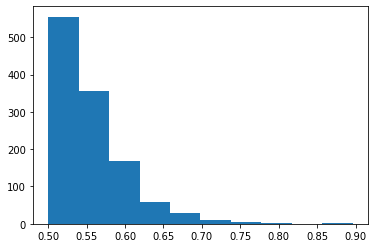

In [ ]:
plt.hist(correct_prob)

In [ ]:
incorrect_prob = 1-output_correct[output_correct['follows?'] == 1].prob_zero

(array([446., 302., 149., 100.,  69.,  37.,  24.,   8.,   6.,   3.]),
 array([0.50006746, 0.53385972, 0.56765199, 0.60144425, 0.63523651,
        0.66902878, 0.70282104, 0.7366133 , 0.77040557, 0.80419783,
        0.83799009]),
 <a list of 10 Patch objects>)

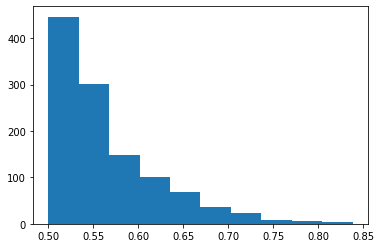

In [ ]:
plt.hist(incorrect_prob)

In [ ]:
output_correct['emoji_sentence_len'] = output_correct['emoji_sentence'].apply(lambda x: len(x))

In [ ]:
output_correct[output_correct['emoji_sentence_len'] == 1]

,index,tweets,emoji_sentence,follows?,prob_zero,emoji_sentence_len
1,42801,Watch your PH balance not my page,🙂,1,0.430891,1
5,44976,15 gcash • like and rt [USER]'s pinned • retwe...,📌,1,0.274290,1
9,75250,Hennessy and dangerous. And I can’t front like...,🙂,0,0.502358,1
12,59363,"Standing at the bus stop today, with my mask o...",😭,0,0.521341,1
13,104893,Man everything be so funny to me I can’t take ...,😔,0,0.509916,1
...,...,...,...,...,...,...
4424,15421,[USER] Ndimi munozonzi my Ex is back in thd pi...,😉,1,0.493969,1
4427,104774,[USER] YES we have a lot of different styles...,😏,0,0.516527,1
4428,37450,[USER] alright then we move just hmu whenever,🤝,1,0.465126,1
4430,18250,self sabotaged at work again and got Mac and c...,😔,1,0.487529,1


In [ ]:
output_incorrect['emoji_sentence_len'] = output_incorrect['emoji_sentence'].apply(lambda x: len(x))

In [ ]:
output_incorrect[output_incorrect['emoji_sentence_len'] == 1]

,index,tweets,emoji_sentence,follows?,prob_zero,emoji_sentence_len
0,77593,You’re just so beautiful,💀,0,0.455134,1
3,40054,Want to tease someone until they cry,😢,1,0.553649,1
4,32019,I’ll figure this out. I always do and I always...,😤,1,0.569586,1
7,35360,[USER] Can you do body rolls too?,🧐,1,0.521023,1
8,76988,good morning,🙄,0,0.249820,1
...,...,...,...,...,...,...
4429,23112,[USER] Hitting the Plymouth tomorrow. If you ...,😁,1,0.568806,1
4431,81505,[USER] [USER] I'm sorry for your loss!,😊,0,0.455440,1
4432,11677,tmap ep. 38 gave us so much happiness. Today's...,😭,1,0.571603,1
4433,14708,Learning to LOVE yourself the RIGHT away it th...,🥰,1,0.583106,1


In [ ]:
df_test['follows?'].value_counts()

0    2259
1    2179
Name: follows?, dtype: int64